Type de tâche : Régression pour prédire le prix de vente d'une propriété.
L'objectif de ce projet est de développer un modèle de régression capable de prédire les prix de vente des propriétés en se basant sur divers attributs.

Entité cible : Agences immobilières.
Le modèle est destiné aux agences immobilières pour les aider à fixer des prix compétitifs qui reflètent la valeur réelle du marché.

In [7]:
# Importation des bibliothèques nécessaires pour la manipulation des données, la visualisation, et les techniques de modélisation.
# Cette étape est cruciale pour configurer notre environnement de travail et assurer que nous avons tous les outils nécessaires pour le traitement des données et la modélisation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import TargetEncoder  # Import du TargetEncoder de sklearn
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# Chargement des données d'entraînement et de test à partir des fichiers CSV fournis.
# Affichage des premières lignes pour vérifier la structure des données.
# Cette étape permet de s'assurer que les données sont correctement importées et de comprendre leur structure initiale.
train_data = pd.read_csv('Data/train.csv',index_col="Id" )
test_data = pd.read_csv('Data/test.csv',index_col="Id" )

# Suppression des ventes partielles pour éviter les biais dans le modèle.
# Les ventes partielles peuvent introduire des anomalies dans la distribution des prix, ce qui peut affecter la précision des prédictions.
train_data = train_data[train_data['SaleCondition'] != 'Partial']

# Définir les colonnes selon leur type (numériques, catégorielles, ordinales, dichotomiques).
# Cela est essentiel pour appliquer des techniques de prétraitement spécifiques à chaque type de donnée.
numeric_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                    'MiscVal', 'MoSold', 'YrSold']

categorical_features = ['MSSubClass', 'MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2', 
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
                        'SaleType', 'SaleCondition']

ordinal_features = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'OverallQual', 
                    'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

dichotomous_features = ['CentralAir', 'Street']



# Pipeline de prétraitement pour les données catégorielles.
# Utilisation de l'imputation des valeurs manquantes par la valeur la plus fréquente et de l'encodage target.
# L'encodage target est utilisé pour transformer les variables catégorielles en valeurs numériques continues, ce qui est utile pour les modèles de régression.
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(target_type='continuous', cv=5, smooth='auto'))
])

# Pipeline de prétraitement pour les données numériques.
# Imputation des valeurs manquantes par la moyenne et normalisation des données.
# La normalisation est essentielle pour que les caractéristiques numériques soient sur une échelle comparable.
numeric_pipeline = Pipeline([
   ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline de prétraitement pour les données ordinales.
# Imputation des valeurs manquantes par la valeur la plus fréquente et encodage ordinal.
# L'encodage ordinal préserve l'ordre des catégories, ce qui est important pour les caractéristiques ordinales.
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Pipeline de prétraitement pour les données dichotomiques.
# Imputation des valeurs manquantes par la valeur la plus fréquente et encodage one-hot.
# L'encodage one-hot est utilisé pour transformer les variables dichotomiques en format binaire.
dichotomous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

# Combinaison des pipelines de prétraitement dans un ColumnTransformer.
# Cette étape permet de regrouper toutes les transformations en une seule structure facile à appliquer.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numeric_pipeline, numeric_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('dich', dichotomous_pipeline, dichotomous_features)  
    ])


# Séparation de la variable cible et des caractéristiques.
# Transformation du prix de vente en utilisant la fonction log1p pour normaliser les valeurs et réduire l'impact des valeurs extrêmes.
y_train = np.log1p(train_data['SalePrice'])
X_train = train_data.drop(['SalePrice'], axis=1)

# Application du ColumnTransformer aux données d'entraînement et de test.
# Cette étape applique toutes les transformations définies précédemment aux données.
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(test_data)

preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('target_encoder',
                                                  TargetEncoder(target_type='continuous'))]),
                                 ['MSSubClass', 'MSZoning', 'Alley',
                                  'Neighborhood', 'Condition1', 'Condition2',
                                  'BldgType', 'HouseStyle', 'RoofStyle',
                                  'RoofMatl', 'Exterior1st', 'Exterior2nd',
                                  'MasVnrType', 'Foundation', 'Heatin...
                                  'OverallCond', 'ExterQual', 'ExterCond',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'KitchenQual', 'Functional', 'FireplaceQu',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'PavedDrive', 'PoolQC', 'Fence']),
                                ('dich',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder())]),
                                 ['CentralAir', 'Street'])])

In [8]:
# Converting back to Pandas DataFrame
X_train_df = pd.DataFrame(X_train_transformed, index=train_data.index)
X_test_df = pd.DataFrame(X_test_transformed, index=test_data.index)

# Afficher les 5 premières lignes du jeu de données prétraité pour vérifier
print(X_train_df.head())
print(X_test_df.head())

           0          1          2          3          4          5   \
Id                                                                     
1   12.317339  12.045248  11.979517  12.147291  11.993675  11.982414   
2   12.000592  12.045248  11.979517  12.281387  11.830000  11.982414   
3   12.305721  12.048223  11.982471  12.138505  12.000103  11.984895   
4   11.965336  12.046648  11.986570  12.235628  12.003914  11.988364   
5   12.317339  12.045248  11.979517  12.665440  11.993675  11.982414   

           6          7          8          9   ...   71   72   73   74   75  \
Id                                              ...                            
1   11.999682  12.151800  11.952662  11.972841  ...  1.0  4.0  4.0  2.0  0.0   
2   11.999682  11.941280  11.952662  11.972841  ...  1.0  4.0  4.0  2.0  0.0   
3   12.003030  12.134273  11.950892  11.976491  ...  1.0  4.0  4.0  2.0  0.0   
4   12.009688  12.147378  11.954087  11.980461  ...  2.0  4.0  4.0  2.0  0.0   
5   11.999682  

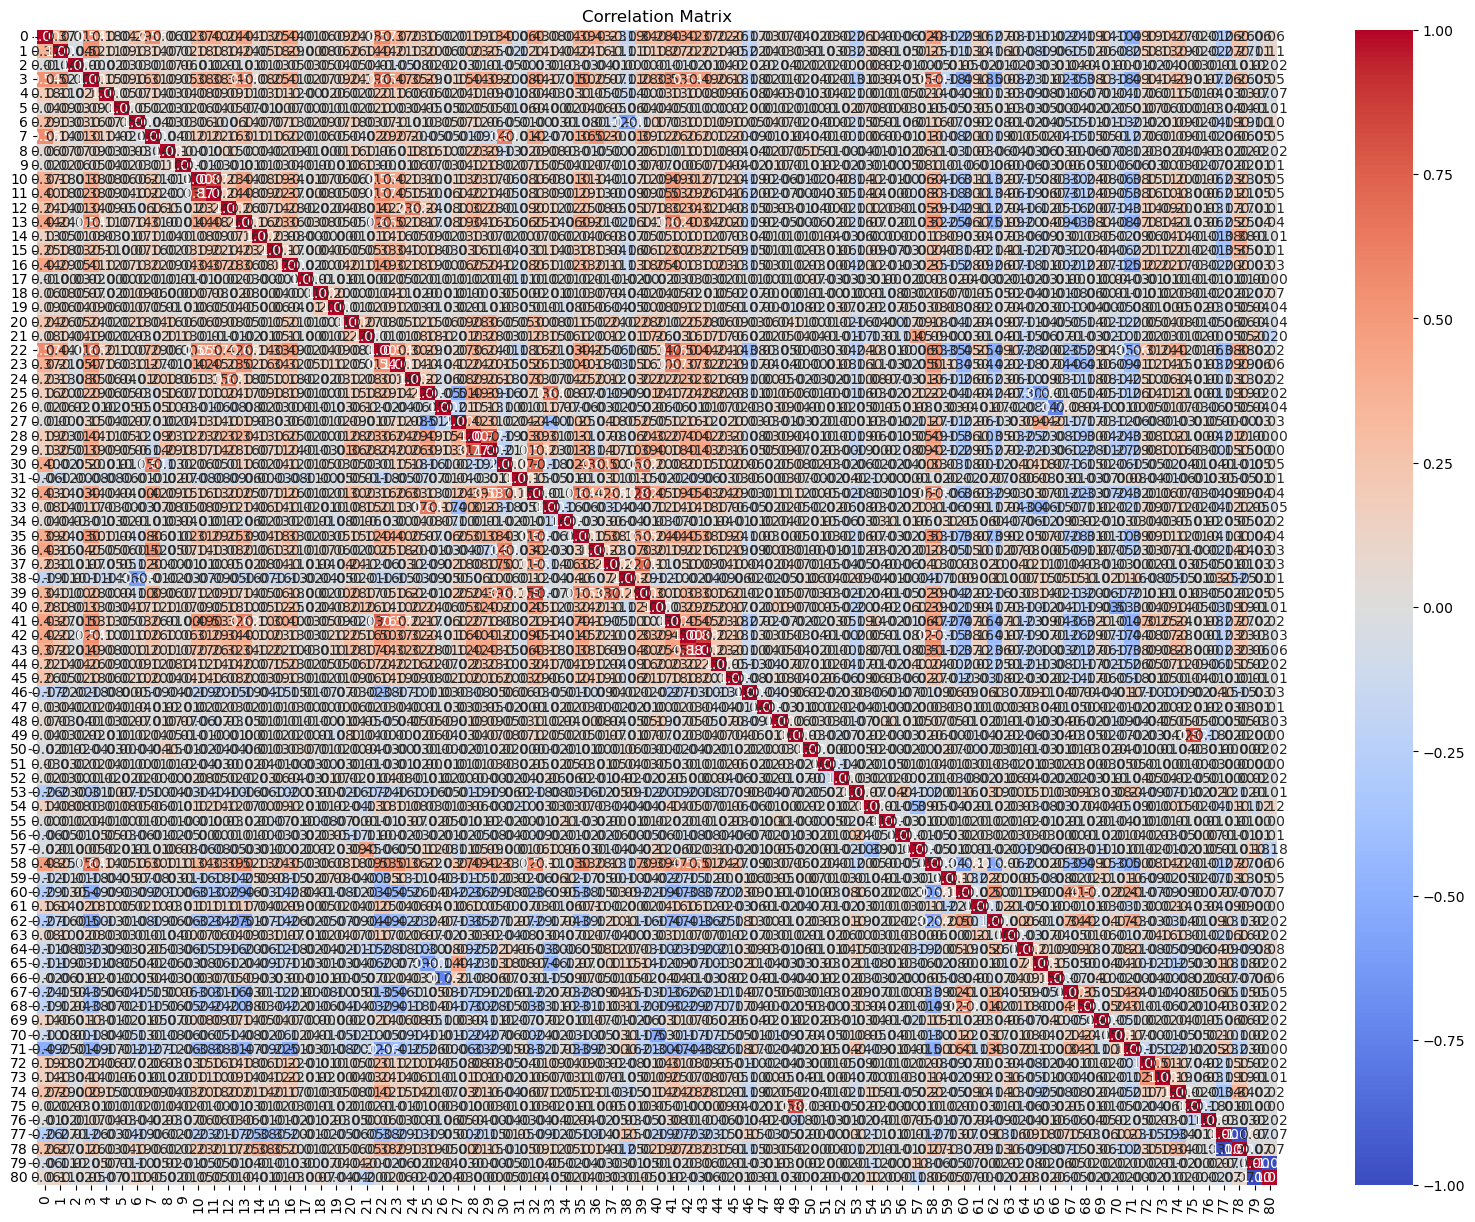

In [9]:
import seaborn as sns
# Calculer la matrice de corrélation
# Cette étape permet de comprendre les relations entre les différentes caractéristiques après la transformation.
# Les matrices de corrélation sont utiles pour identifier les caractéristiques fortement corrélées qui peuvent affecter la performance du modèle.
# Référence cours: Analyse exploratoire des données.
correlation_matrix = X_train_df.corr()


# Afficher la matrice de corrélation
# La visualisation de la matrice de corrélation avec une heatmap permet de repérer rapidement les corrélations élevées entre les variables.
# Référence ML Canevas: Compréhension des données - Analyse exploratoire des données.
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Analyse de la matrice de corrélation:
La matrice de corrélation montre que certaines variables sont fortement corrélées entre elles, par exemple :
 - '1stFlrSF' et 'TotalBsmtSF' (0.82) : Cela indique que la superficie du premier étage est fortement corrélée avec la superficie totale du sous-sol.
 - 'GrLivArea' et 'TotRmsAbvGrd' (0.83) : Cela montre une forte corrélation entre la surface habitable au-dessus du sol et le nombre total de pièces au-dessus du sol.
 - 'GarageCars' et 'GarageArea' (0.88) : Il y a une forte corrélation entre le nombre de voitures pouvant être garées et la superficie du garage.
Ces fortes corrélations peuvent indiquer une redondance de l'information entre les variables, ce qui peut être pris en compte lors de la sélection des caractéristiques ou de la régularisation du modèle.

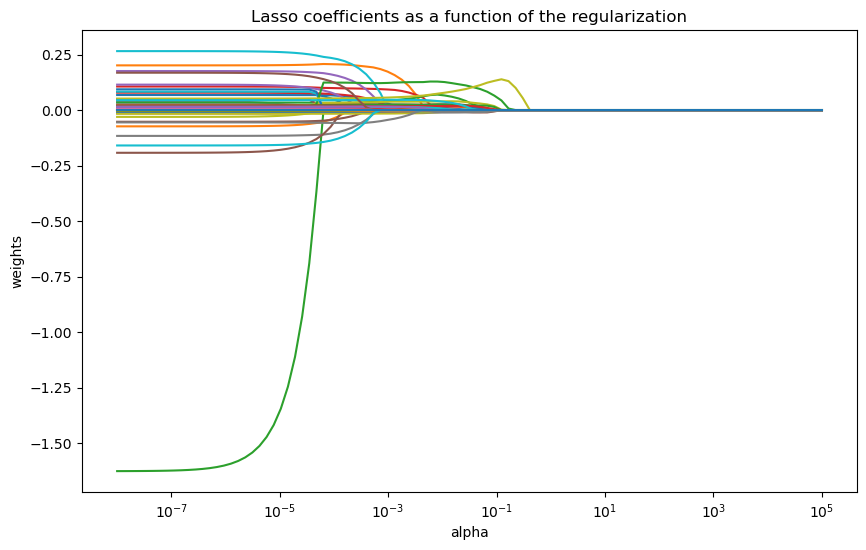

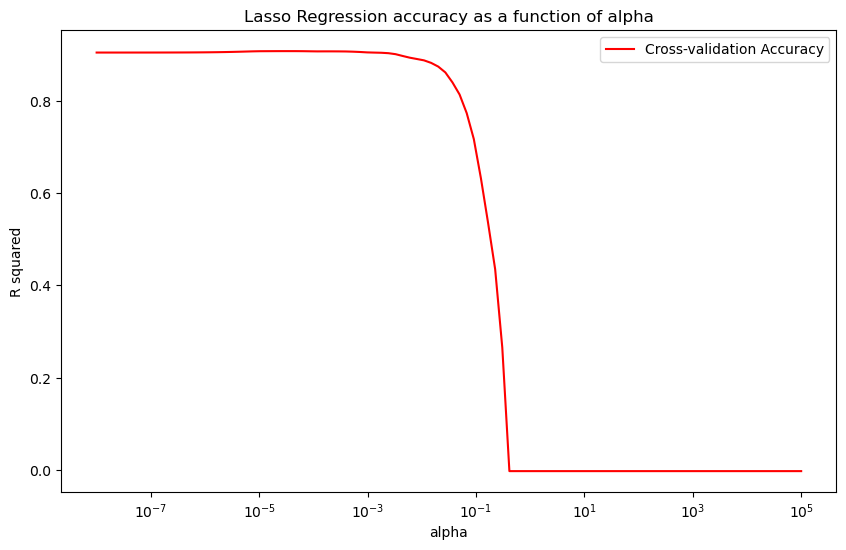

In [14]:
# Définir les alphas pour Lasso
# Les alphas sont les paramètres de régularisation qui contrôlent la complexité du modèle Lasso.
# Nous utilisons une gamme large d'alphas pour trouver la meilleure valeur de régularisation.
lasso_alphas = 10**np.linspace(-8, 5, 100)

# Entraînement de la régression Lasso et collecte des coefficients
# Pour chaque valeur de alpha, nous entraînons un modèle Lasso et enregistrons les coefficients et les scores de validation croisée.
lasso_regression = Lasso(max_iter=10000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X_train_df, y_train)
    lasso_coefs.append(lasso_regression.coef_)
    lasso_cv.append(cross_val_score(lasso_regression, X_train_df, y_train, cv=5, scoring='r2').mean())

# Tracer les coefficients en fonction des alphas
# Ce graphique montre comment les coefficients des caractéristiques changent en fonction de la régularisation.
# Lorsque alpha augmente, la régularisation devient plus forte, ce qui pousse les coefficients vers zéro.
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.show()

# Tracer la précision en fonction des alphas
# Ce graphique montre comment la précision du modèle (R^2) change en fonction de la régularisation.
# Il aide à identifier la valeur optimale de alpha qui maximise la précision du modèle.
plt.figure(figsize=(10, 6))
plt.plot(lasso_alphas, lasso_cv, color='red', label='Cross-validation Accuracy')

# Ajouter des titres et des étiquettes
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R squared')
plt.title('Lasso Regression accuracy as a function of alpha')
plt.legend()

# Afficher le graphique
plt.show()

Analyse du graphique des coefficients Lasso en fonction de la régularisation:
Le graphique montre que lorsque alpha augmente (vers la droite), les coefficients des variables diminuent progressivement.
Certains coefficients deviennent exactement zéro, ce qui indique une sélection de caractéristiques effectuée par Lasso.
Cela aide à éviter le surapprentissage (overfitting) et simplifie le modèle en éliminant les variables moins importantes.

Analyse du graphique de précision:
Le graphique montre que la précision du modèle (R^2) varie avec la valeur de alpha.
Une petite valeur de alpha (faible régularisation) permet aux coefficients de rester proches de leurs valeurs non régularisées, ce qui peut entraîner un surapprentissage.
La précision est élevée pour les petites valeurs de alpha.
À mesure que alpha augmente légèrement, la précision reste stable, indiquant que le modèle peut maintenir une bonne performance avec une régularisation modérée.
Lorsque alpha atteint environ 0.1, la précision commence à diminuer rapidement, indiquant que la régularisation devient trop forte et que le modèle commence à sous-apprendre.
Pour des valeurs très élevées de alpha, la précision tombe à zéro, indiquant un modèle trop régularisé incapable de capturer les relations dans les données.
L'objectif est de trouver un équilibre optimal de alpha qui maximise la précision du modèle tout en évitant le sur- ou sous-apprentissage.

In [11]:
# Afficher les statistiques descriptives des données transformées
# Les statistiques descriptives permettent de résumer les caractéristiques principales des données transformées.
# Cela inclut des informations comme la moyenne, l'écart-type, les valeurs minimales et maximales, ainsi que les quartiles.
# Ces informations sont utiles pour comprendre la distribution des données après le prétraitement et pour identifier d'éventuelles anomalies ou tendances.
print(X_train_df.describe())

# Analyse des statistiques descriptives:
# - `count`: Toutes les variables ont 1335 observations, indiquant qu'il n'y a pas de valeurs manquantes après le prétraitement.
# - `mean`: Les moyennes sont proches les unes des autres, suggérant une échelle similaire pour toutes les variables après la normalisation.
# - `std`: L'écart-type varie, certaines variables ayant plus de variabilité que d'autres.
# - `min` et `max`: Les valeurs minimales et maximales montrent l'étendue des données pour chaque variable, utile pour détecter des valeurs extrêmes.
# - `25%`, `50%` et `75%`: Les quartiles fournissent des informations sur la distribution des données, la médiane étant une mesure centrale clé.

# Afficher quelques lignes des données transformées
# L'affichage des premières lignes des données transformées permet de vérifier que le prétraitement a été effectué correctement.
# Cela donne un aperçu des valeurs des caractéristiques après l'imputation, la normalisation et l'encodage.
print(X_train_df.head())

                0            1            2            3            4   \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000   
mean     11.985143    11.985727    11.984247    11.984322    11.984552   
std       0.219954     0.153378     0.006353     0.273974     0.078805   
min      11.426464    11.171024    11.927737    11.418619    11.728142   
25%      11.831869    12.045248    11.982471    11.735833    11.993675   
50%      12.000052    12.046648    11.985899    11.908211    12.003231   
75%      12.114121    12.048223    11.986570    12.149652    12.003914   
max      12.317339    12.234254    12.021157    12.675100    12.414436   

                5            6            7            8            9   ...  \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000  ...   
mean     11.983947    11.984728    11.984047    11.984767    11.983261  ...   
std       0.035741     0.069810     0.124580     0.063180     0.049991  ...   
min      11.13460

Analyse des premières lignes des données transformées:
 - Les premières lignes montrent des exemples concrets des valeurs transformées.
 - Cela permet de vérifier visuellement que l'imputation, l'encodage et la normalisation ont été correctement appliqués.
 - Ces valeurs fournissent un aperçu rapide de la manière dont les données d'entraînement sont structurées après prétraitement.

In [13]:
# Choisir la meilleure valeur d'alpha
# Nous utilisons les scores de validation croisée pour trouver la valeur d'alpha qui maximise la précision du modèle (R^2).
# La fonction np.argmax() est utilisée pour trouver l'indice de la meilleure valeur d'alpha basée sur les scores de validation croisée.
best_alpha_index = np.argmax(lasso_cv)
best_alpha = lasso_alphas[best_alpha_index]

# Afficher la meilleure valeur d'alpha
# Cette étape affiche la valeur d'alpha qui a donné le meilleur score de validation croisée.
# La meilleure valeur d'alpha est celle qui équilibre la régularisation et la performance du modèle, évitant à la fois le surapprentissage et le sous-apprentissage.
print(f"La meilleure valeur d'alpha est : {best_alpha}")



La meilleure valeur d'alpha est : 2.5950242113997373e-05


Analyse de la sélection de la meilleure valeur d'alpha:
 - La meilleure valeur d'alpha est sélectionnée en utilisant les scores de validation croisée.
 - Cela garantit que nous choisissons une valeur d'alpha qui optimise la performance du modèle sur des données de validation, et non uniquement sur les données d'entraînement.
 - En affichant la meilleure valeur d'alpha, nous pouvons l'utiliser pour entraîner notre modèle final de régression Lasso, assurant ainsi la meilleure performance possible.

In [15]:
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import xgboost as xgb

# Fonction de score RMSLE
# La Root Mean Squared Log Error (RMSLE) est utilisée pour évaluer les prédictions du modèle.
# Cette métrique est appropriée lorsque les valeurs cibles ont une large gamme de valeurs et/ou des valeurs extrêmes.
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Critères de succès et analyse critique des scores RMSLE
# Les critères de succès pour évaluer la performance des modèles sont basés sur les scores RMSLE. 
# Un RMSLE inférieur indique une meilleure performance, en particulier pour les modèles de régression où l'on souhaite que les prédictions soient proportionnellement proches des valeurs réelles.
# Pour ce projet, un RMSLE inférieur à 0.2 est considéré comme un bon résultat, indiquant que les prédictions sont en moyenne à moins de 20% de la valeur réelle.
# Les scores RMSLE moyens obtenus par les modèles XGBoost et AdaBoost seront analysés pour déterminer si les modèles répondent à ce critère de succès.

# Préparer les données pour Optuna
# X_preprocessed contient les caractéristiques transformées, et y contient la variable cible.
X_preprocessed = X_train_df
y = y_train

# Définir l'objectif pour Optuna
# Cette fonction définit l'objectif d'optimisation pour Optuna, en spécifiant les hyperparamètres à optimiser pour XGBoost.
def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': 1e-4,  # Utiliser la valeur ajustée d'alpha
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }

    model = xgb.XGBRegressor(**xgb_params, random_state=42, objective='reg:squarederror')
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train, X_valid = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train, np.log1p(y_train), early_stopping_rounds=50, eval_set=[(X_valid, np.log1p(y_valid))], verbose=False)
        preds = model.predict(X_valid)
        score = rmsle(np.log1p(y_valid), preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

# Utiliser Optuna pour l'optimisation bayésienne
# Optuna est une bibliothèque pour l'optimisation automatique des hyperparamètres en utilisant des techniques bayésiennes.
# Le TPESampler est utilisé pour une optimisation efficace.
sampler = optuna.samplers.TPESampler()
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=200)  # Augmentation du nombre d'essais pour une meilleure optimisation des hyperparamètres

# Afficher les meilleurs hyperparamètres trouvés par Optuna
print("Best hyperparameters for XGB =", study_xgb.best_trial.params)

# Entraîner le modèle final avec les meilleurs hyperparamètres
# Le modèle final est entraîné sur toutes les données d'entraînement en utilisant les meilleurs hyperparamètres trouvés par Optuna.
final_model_xgb = xgb.XGBRegressor(**study_xgb.best_trial.params, random_state=42, objective='reg:squarederror')
final_model_xgb.fit(X_train_df, y_train)  # Utiliser toutes les données d'entraînement


[I 2024-06-01 12:35:11,956] A new study created in memory with name: no-name-d609d35c-d4af-49dd-93d8-f1b0214d6b8b
c:\Users\blerdon\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopp

Best hyperparameters for XGB = {'n_estimators': 1065, 'max_depth': 3, 'learning_rate': 0.03333321547907155, 'subsample': 0.617994419016521, 'colsample_bytree': 0.373488418974783, 'min_child_weight': 2, 'reg_lambda': 1.5749562425149138e-05, 'gamma': 3.814812050019763e-07}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.373488418974783, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.814812050019763e-07,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03333321547907155,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1065, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Prédictions sur les données de test pour XGBoost
# Utilisation du modèle final XGBoost entraîné pour prédire les valeurs cibles des données de test.
# Cela permet d'obtenir les prédictions pour les données non vues pendant l'entraînement, ce qui est crucial pour évaluer la performance du modèle sur des données réelles.
y_test_pred_xgb = final_model_xgb.predict(X_test_df)
# Prédictions sur les données de formation pour XGBoost
# Nous effectuons également des prédictions sur les données de formation pour analyser la performance du modèle sur l'ensemble d'entraînement.
y_train_pred_xgb = final_model_xgb.predict(X_train_df)

# Revenir à l'échelle normale
# Les prédictions et les valeurs réelles ont été transformées avec log1p pour la normalisation.
# Nous utilisons expm1 pour revenir à l'échelle normale afin de pouvoir interpréter les résultats dans leur unité originale (prix de vente).
y_test_pred_xgb = np.expm1(y_test_pred_xgb)
y_train_pred_xgb = np.expm1(y_train_pred_xgb)
y_train_true = np.expm1(y_train)

Analyse des prédictions :
 - Les prédictions sur les données de test (y_test_pred_xgb) permettent d'évaluer la capacité du modèle à généraliser sur des données non vues.
 - Les prédictions sur les données de formation (y_train_pred_xgb) permettent de vérifier l'ajustement du modèle sur les données d'entraînement.
 - Le retour à l'échelle normale (expm1) permet d'interpréter les prédictions en termes de prix de vente réels.

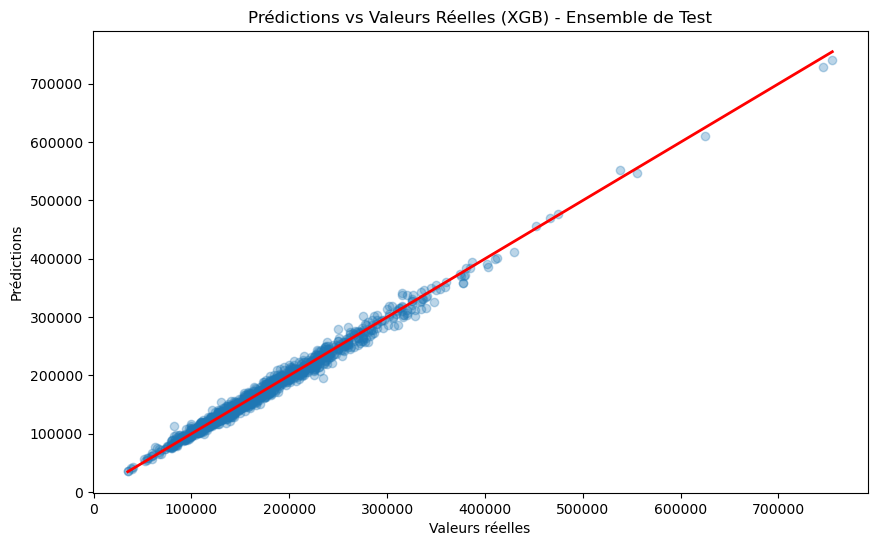

In [17]:
# Tracer les prédictions vs valeurs réelles pour l'ensemble de test
# Cette visualisation permet de comparer les prédictions du modèle avec les valeurs réelles.
# Un bon modèle aura ses prédictions proches de la ligne rouge (y = x), ce qui signifie que les prédictions sont similaires aux valeurs réelles.
plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred_xgb, alpha=0.3)
plt.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)], color='red', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles (XGB) - Ensemble de Test')
plt.show()

Analyse du graphique Prédictions vs Valeurs Réelles :
 - Le graphique montre la relation entre les valeurs réelles et les prédictions faites par le modèle XGBoost.
 - Les points de données représentent les paires (valeur réelle, prédiction).
 - La ligne rouge (y = x) représente les points où les prédictions sont exactement égales aux valeurs réelles.
 - Un bon ajustement est indiqué par les points proches de cette ligne rouge, ce qui suggère que les prédictions sont précises.
 - Les écarts significatifs par rapport à la ligne rouge peuvent indiquer des erreurs de prédiction ou des zones où le modèle pourrait être amélioré.
 - La proximité des points à la ligne rouge dans ce graphique indique que le modèle XGBoost est bien calibré et a une bonne capacité prédictive.
 - La légère dispersion des points autour de la ligne rouge est normale et indique des erreurs de prédiction relativement faibles et uniformément réparties.
 - Les valeurs extrêmes sont également bien prédites, montrant que le modèle généralise bien sur l'ensemble des données, y compris les valeurs extrêmes.
 - En conclusion, le modèle XGBoost démontre une haute précision et un faible biais dans les prédictions, confirmant son efficacité pour prédire les prix de vente dans ce contexte.

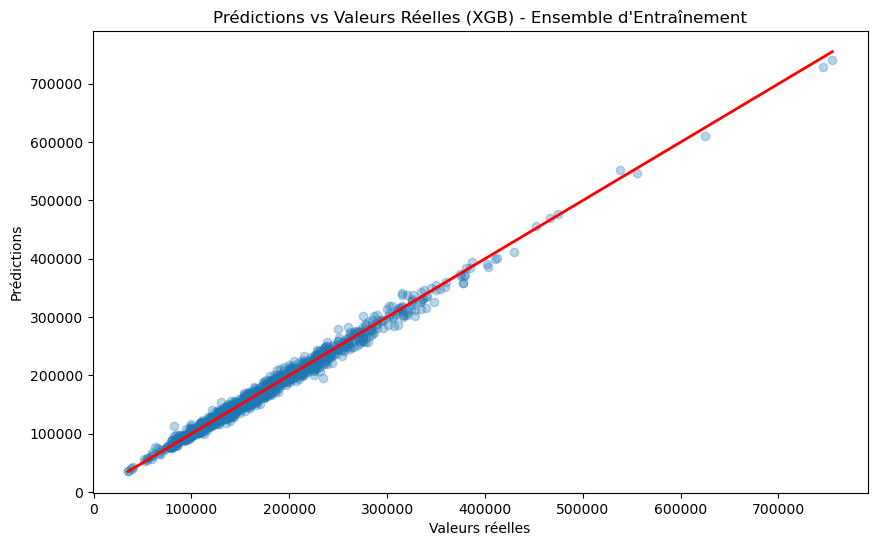

In [18]:
# Tracer les prédictions vs valeurs réelles pour l'ensemble d'entraînement
# Cette visualisation permet de comparer les prédictions du modèle avec les valeurs réelles sur l'ensemble d'entraînement.
# Un bon modèle aura ses prédictions proches de la ligne rouge (y = x), ce qui signifie que les prédictions sont similaires aux valeurs réelles.
plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred_xgb, alpha=0.3)
plt.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)], color='red', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles (XGB) - Ensemble d\'Entraînement')
plt.show()

Analyse du graphique Prédictions vs Valeurs Réelles (Ensemble d'Entraînement) :
 - Le graphique montre la relation entre les valeurs réelles et les prédictions faites par le modèle XGBoost sur l'ensemble d'entraînement.# - Les points de données représentent les paires (valeur réelle, prédiction).
 - La ligne rouge (y = x) représente les points où les prédictions sont exactement égales aux valeurs réelles.
 - Un bon ajustement est indiqué par les points proches de cette ligne rouge, ce qui suggère que les prédictions sont précises.
 - Les écarts significatifs par rapport à la ligne rouge peuvent indiquer des erreurs de prédiction ou des zones où le modèle pourrait être amélioré.

In [15]:
###RANDOM FOREST 

In [26]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
def objective_adaboost(trial):
    ab_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', 1, 10)
    }

    base_estimator = DecisionTreeRegressor(max_depth=ab_params.pop('base_estimator__max_depth'))
    model = AdaBoostRegressor(base_estimator=base_estimator, **ab_params, random_state=42)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_valid_fold)
        score = rmsle(y_valid_fold, preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

# Utiliser Optuna pour l'optimisation bayésienne
# Optuna est utilisé pour optimiser les hyperparamètres du modèle AdaBoost.
sampler = optuna.samplers.TPESampler()
study_ab = optuna.create_study(direction='minimize', sampler=sampler)
study_ab.optimize(objective_adaboost, n_trials=100)

# Afficher les meilleurs hyperparamètres trouvés par Optuna
print("Best hyperparameters for AdaBoost =", study_ab.best_trial.params)

# Entraîner le modèle final avec les meilleurs hyperparamètres pour AdaBoost
# Les meilleurs hyperparamètres trouvés par Optuna sont utilisés pour entraîner le modèle final.
best_params = study_ab.best_trial.params
base_estimator = DecisionTreeRegressor(max_depth=best_params.pop('base_estimator__max_depth'))
final_model_ab = AdaBoostRegressor(base_estimator=base_estimator, **best_params, random_state=42)
final_model_ab.fit(X_preprocessed, y)  # Utiliser toutes les données d'entraînement

# Évaluation finale du modèle AdaBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_rmsle_scores_ab = []

for train_index, valid_index in kf.split(X_preprocessed):
    X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
    
    final_model_ab.fit(X_train_fold, y_train_fold)
    preds = final_model_ab.predict(X_valid_fold)
    score = rmsle(y_valid_fold, preds)
    final_rmsle_scores_ab.append(score)

print(f"Final RMSLE scores (AdaBoost): {final_rmsle_scores_ab}")
print(f"Mean Final RMSLE (AdaBoost): {np.mean(final_rmsle_scores_ab)}")
# Prédictions sur les données de test pour AdaBoost
y_test_pred_ab = final_model_ab.predict(X_test_df)
y_test_pred_ab = np.expm1(y_test_pred_ab)

[I 2024-06-01 17:59:33,566] A new study created in memory with name: no-name-cacd69b4-d641-4ce8-a1df-3c2b6a6bb1c5
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator

Best hyperparameters for AdaBoost = {'n_estimators': 1014, 'learning_rate': 0.9998081383009254, 'base_estimator__max_depth': 8}


c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Final RMSLE scores (AdaBoost): [0.010874347709420213, 0.011000396753059062, 0.011011731519521194, 0.011151226320857969, 0.008744674674031498]
Mean Final RMSLE (AdaBoost): 0.010556475395377986


In [27]:
# Préparer les fichiers de soumission
submission_xgb = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_xgb
})

submission_rf = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_ab
})

# Sauvegarder les fichiers de soumission
submission_xgb.to_csv('submission_xgb.csv', index=False)
submission_rf.to_csv('submission_AB.csv', index=False)

print("Les fichiers de soumission sont prêts : 'submission_xgb.csv' et 'submission_AB.csv'")


Les fichiers de soumission sont prêts : 'submission_xgb.csv' et 'submission_AB.csv'


# Using MLFlow for evaluation
<p>The best model is saved in MLFlow for later use.</p>

In [29]:
# pip install mlflow
# pip install setuptools

<p>After installing mlflow, we first need to start a local tracking server. Execute the following command in the terminal:</p>



### mlflow server --host 127.0.0.1 --port 8080


In [32]:
import mlflow
from mlflow.models import infer_signature

# Configurer l'URI de suivi MLflow
# MLflow permet de suivre les expériences de machine learning et de gérer les modèles. 
# La configuration de l'URI de suivi indique où les informations de suivi seront stockées.
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("House Prices Prediction")

# Entraîner et enregistrer le modèle final XGBoost avec MLflow
# Un contexte d'exécution est créé pour le suivi d'une exécution spécifique. Cela permet de regrouper les informations liées à cette exécution.
with mlflow.start_run(run_name="XGBoost Model"):
    best_params_xgb = study_xgb.best_trial.params
    final_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42, objective='reg:squarederror')
    
    model_pipeline_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_xgb)
    ])
    
    # Entraîner le pipeline avec les données d'entraînement
    model_pipeline_xgb.fit(X_train, y_train)
    
    # Enregistrer les hyperparamètres utilisés
    mlflow.log_params(best_params_xgb)

    # Calculer et enregistrer la métrique de perte (RMSLE)
    mean_rmsle_xgb = np.mean([rmsle_score for rmsle_score in study_xgb.trials_dataframe()['value']])
    mlflow.log_metric("mean_rmsle", mean_rmsle_xgb)

    # Définir un tag pour décrire l'exécution
    mlflow.set_tag("Training Info", "XGBoost Regressor")

    # Inférer la signature du modèle (entrée et sortie)
    signature_xgb = infer_signature(X_train, model_pipeline_xgb.predict(X_train))

    # Enregistrer le modèle avec MLflow
    model_info_xgb = mlflow.sklearn.log_model(
        sk_model=model_pipeline_xgb,
        signature=signature_xgb,
        input_example=X_train.head(),
        registered_model_name="xgboost_regressor_model",
        artifact_path="xgboost_regressor_model"
    )

print("Le modèle XGBoost a été enregistré avec MLflow.")



2024/06/01 23:11:49 INFO mlflow.tracking.fluent: Experiment with name 'House Prices Prediction_XGBOOST' does not exist. Creating a new experiment.


c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'xgboost_regressor_model'.
2024/06

Le modèle XGBoost a été enregistré avec MLflow.


Created version '1' of model 'xgboost_regressor_model'.


In [33]:
# Entraîner et enregistrer le modèle final AdaBoost avec MLflow
with mlflow.start_run(run_name="AdaBoost Model"):
    best_params_ab = study_ab.best_trial.params
    base_estimator_ab = DecisionTreeRegressor(max_depth=best_params_ab.pop('base_estimator__max_depth'))
    final_model_ab = AdaBoostRegressor(base_estimator=base_estimator_ab, **best_params_ab, random_state=42)
    
    # Création d'un pipeline comprenant le préprocesseur et le modèle de régression
    model_pipeline_ab = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_ab)
    ])
    
    # Entraîner le pipeline avec les données d'entraînement
    model_pipeline_ab.fit(X_train, y_train)
    
    # Enregistrer les hyperparamètres utilisés
    mlflow.log_params(best_params_ab)

    # Calculer et enregistrer la métrique de perte (RMSLE)
    mean_rmsle_ab = np.mean([rmsle_score for rmsle_score in study_ab.trials_dataframe()['value']])
    mlflow.log_metric("mean_rmsle", mean_rmsle_ab)

    # Définir un tag pour décrire l'exécution
    mlflow.set_tag("Training Info", "AdaBoost Regressor")

    # Inférer la signature du modèle (entrée et sortie)
    signature_ab = infer_signature(X_train, model_pipeline_ab.predict(X_train))

    # Enregistrer le modèle avec MLflow
    model_info_ab = mlflow.sklearn.log_model(
        sk_model=model_pipeline_ab,
        signature=signature_ab,
        input_example=X_train.head(),
        registered_model_name="adaboost_regressor_model",
        artifact_path="adaboost_regressor_model"
    )

print("Le modèle AdaBoost a été enregistré avec MLflow.")

c:\Users\blerdon\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'adaboost_regresso

Le modèle AdaBoost a été enregistré avec MLflow.


Created version '1' of model 'adaboost_regressor_model'.
